In [1]:
import numpy as np
import pandas as pd
import sys
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("/Users/clemens/Documents/Code/AnalysisToolbox")

import spikeAnalysisToolsV2.data_loading as data
import spikeAnalysisToolsV2.firing_rates as firing
import spikeAnalysisToolsV2.helper as helper
import spikeAnalysisToolsV2.overviews as overview

# Set Params for the Data

In [2]:
## set the Masterpath to the folder where your output is saved

masterpath = "/Users/clemens/Documents/Code/ModelClemens/Build/output"
## set the subfolder to the Simulation you want to analyse 

subfolders = [

            "2017:10:18-12:56:59_test_100_epochs"

            ]
## if more than the inital epoch is needed *1 needs to be run
extensions = [
            "initial",
            "testing/epoch1",
            "testing/epoch2" 
             ]

# info_neurons is just an array of the information from above. This makes it easier to run the functions and pass the information. 
# info_times same for times
network_architecture = dict(
    num_exc_neurons_per_layer = 64*64,
    num_inh_neurons_per_layer = 32*32,
    num_layers = 4,
    #total_per_layer = num_exc_neurons_per_layer + num_inh_neurons_per_layer,
    #total_network = total_per_layer * num_layers,
    #num_stimuli = 16
)

info_times = dict(
    length_of_stimulus = 2.0,
    num_stimuli = 16,
    time_start = 1.5,
    time_end = 1.9
)

# Import the Data

In [3]:
spikes = data.load_spikes_from_subfolders(masterpath, subfolders, extensions, False)
np.max(spikes[0][1].times)

Start


63.766724

# Visualizing Spikes
Display a scatter plots of all the spikes in all layers.

Takes quite a long time so change the field type to Raw or Code depending on wether you wanna run it.

# Analysis of Firing Rates
### Calculating the firing rates for all stimuli in a nested structure 
It has the shape [subfolder][extension][stimulus][layer][exitator/inhibitory]
-> Idea is going more and more into detail

In [4]:
start = timer()
rates_subfolders = firing.calculate_rates_subfolder(
    spikes,
    network_architecture, 
    info_times)
print("Calulating Firing Rates took {}s".format(timer() - start))

Calulating Firing Rates took 1.8333488920179661s


### Print out an overview over the firing rates:

In [5]:
overview.print_firing_rates_tables(rates_subfolders, info_times, subfolders, extensions, True)

2017:10:18-12:56:59_test_100_epochs
Extension:  initial
Layer 0 
              Exc Mean  Exc Min  Exc Max  Inh Mean  Inh Min  Inh Max
Stimulus 0   0.616455      0.0     87.5  2.084961      0.0    107.5
Stimulus 1   0.584106      0.0     72.5  1.972656      0.0     85.0
Stimulus 2   0.606079      0.0     80.0  2.221680      0.0     95.0
Stimulus 3   0.644531      0.0     72.5  2.121582      0.0    102.5
Stimulus 4   0.640259      0.0     80.0  2.214355      0.0     90.0
Stimulus 5   0.639648      0.0     72.5  2.224121      0.0     90.0
Stimulus 6   0.680542      0.0     80.0  2.304688      0.0     85.0
Stimulus 7   0.670776      0.0     87.5  2.385254      0.0     87.5
Stimulus 8   0.646362      0.0     67.5  2.197266      0.0    112.5
Stimulus 9   0.648804      0.0     72.5  2.119141      0.0    100.0
Stimulus 10  0.609741      0.0     70.0  2.309570      0.0    105.0
Stimulus 11  0.635376      0.0     75.0  2.331543      0.0    117.5
Stimulus 12  0.589600      0.0     77.5  1.962891 

### Visualize individual neurons firing rates:
Plot showing the firing rates for each neuron with the neuron sorted according to its rank (in terms of its firing rate)

/Users/clemens/.virtualenvs/scipy/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


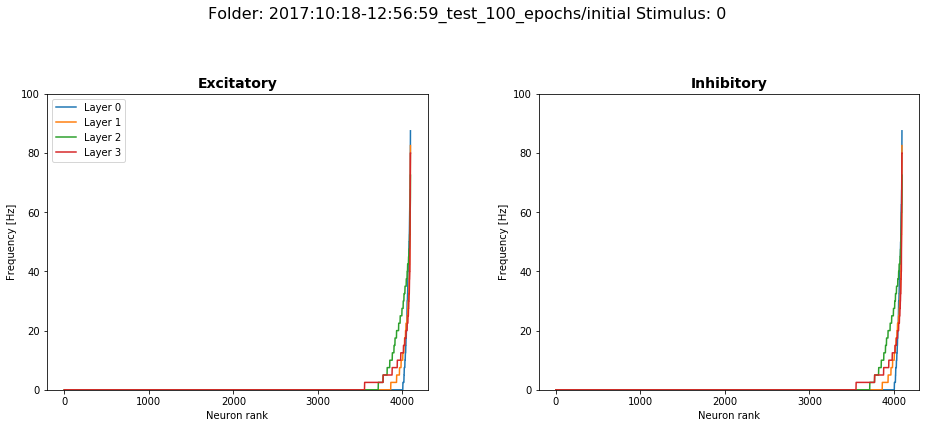

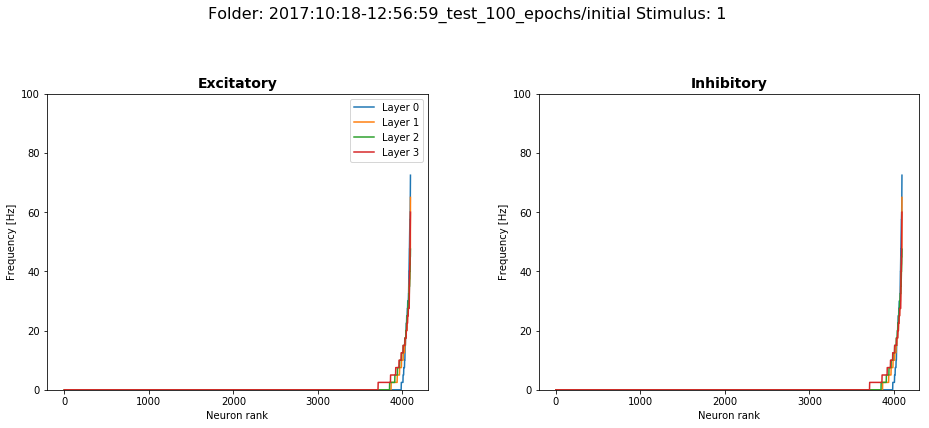

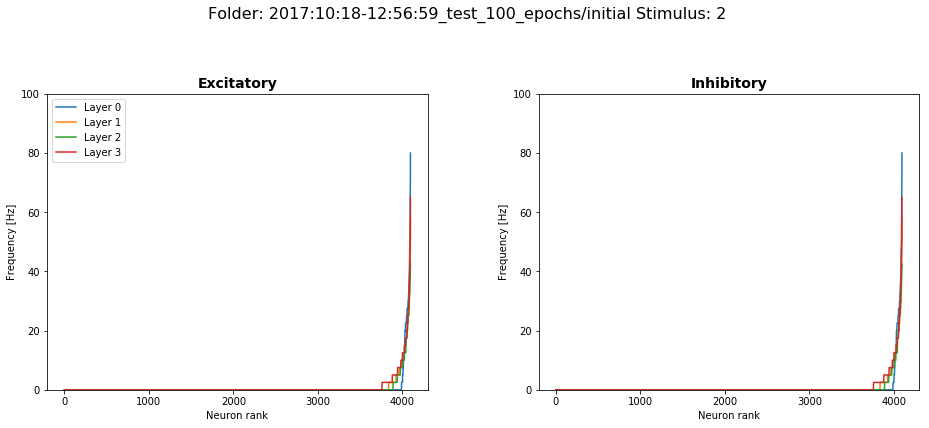

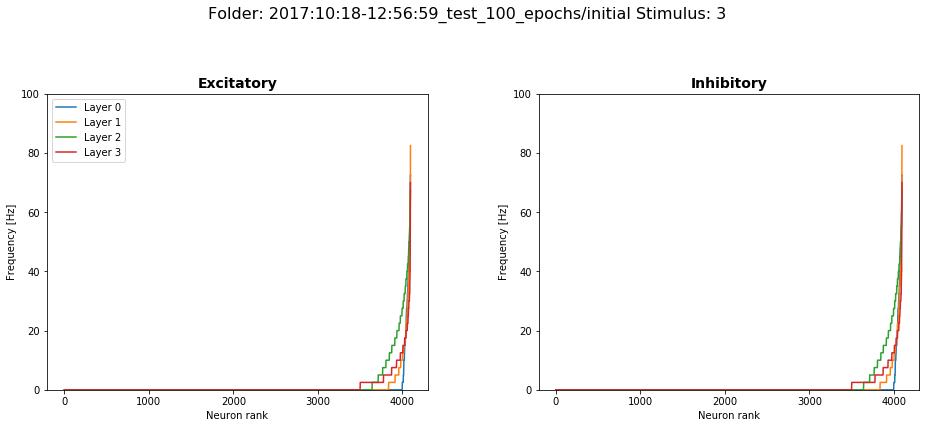

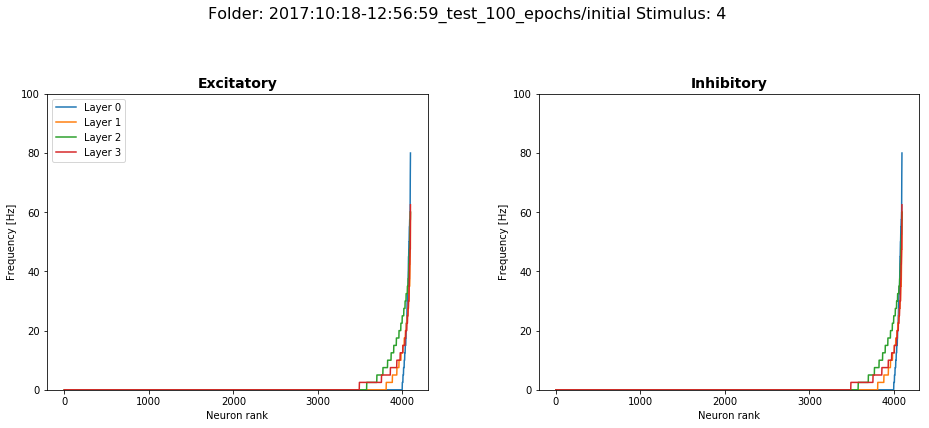

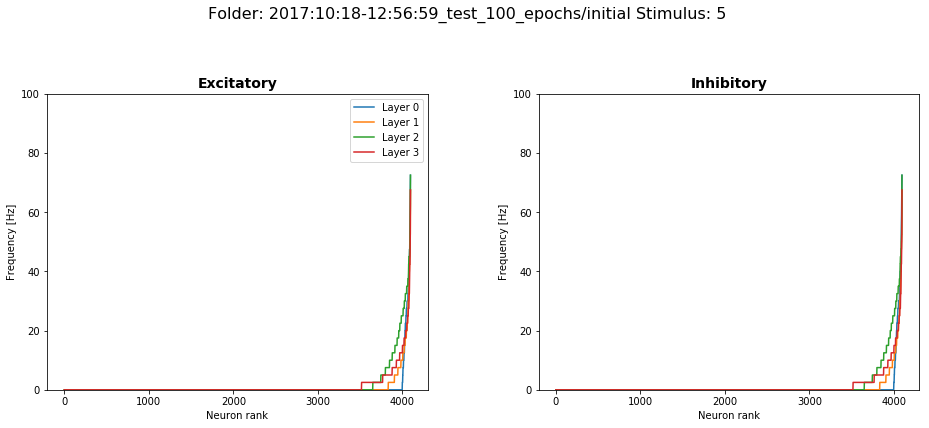

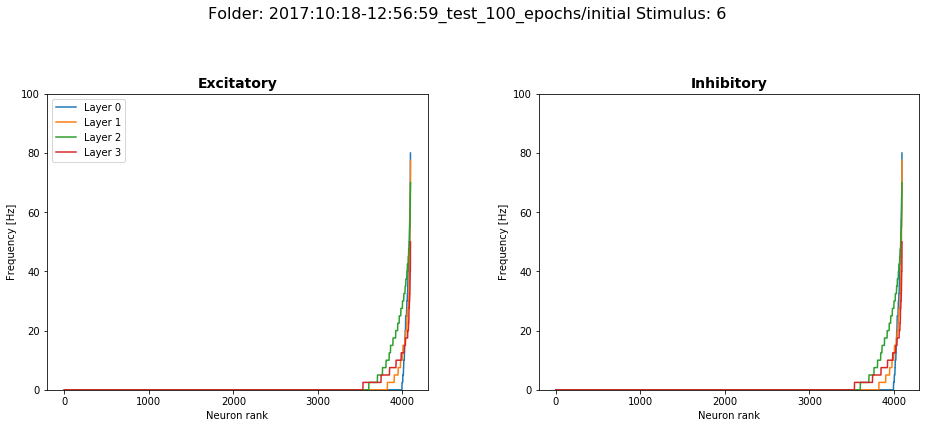

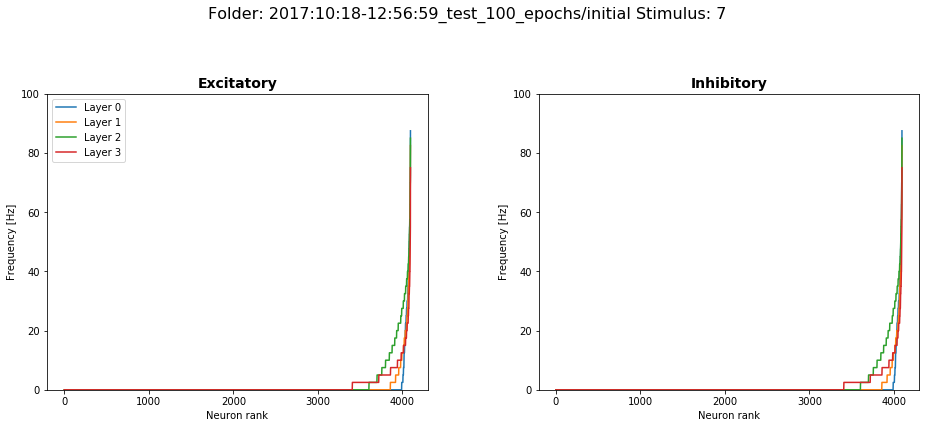

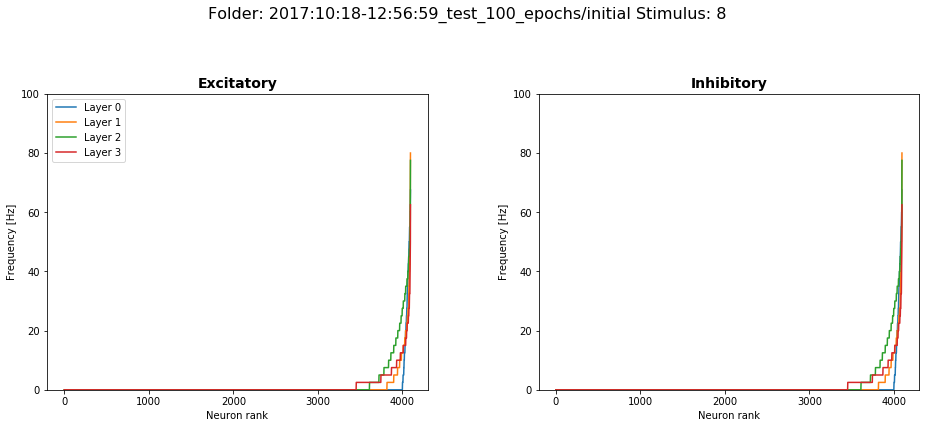

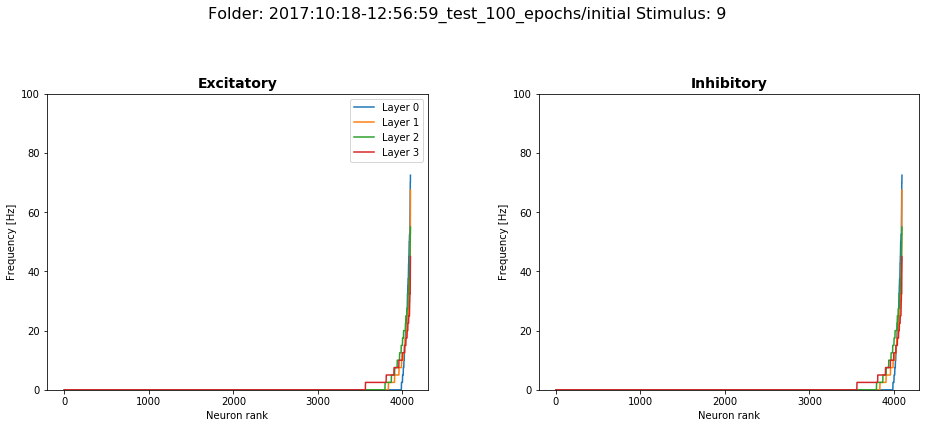

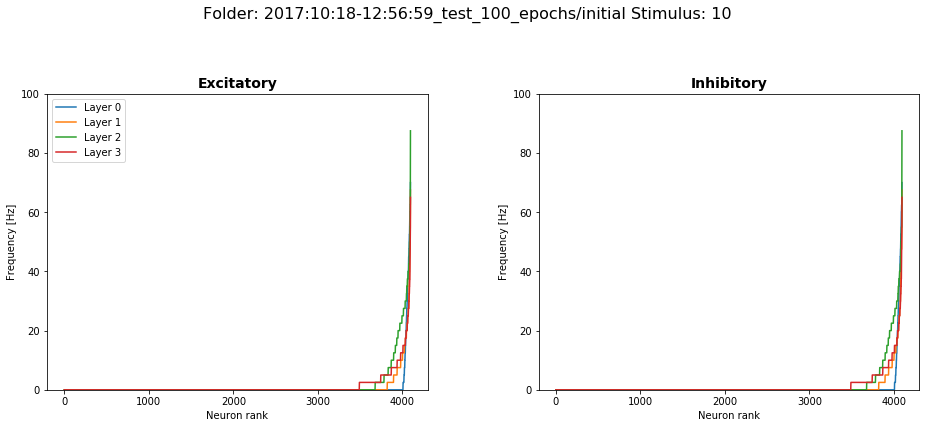

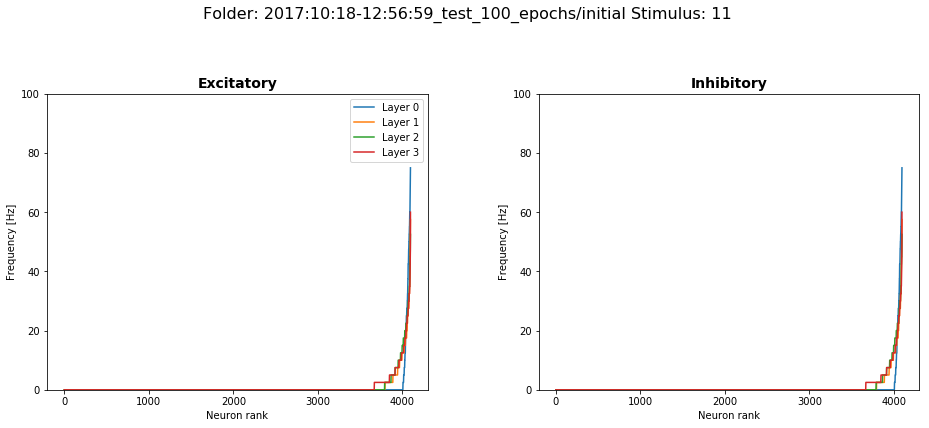

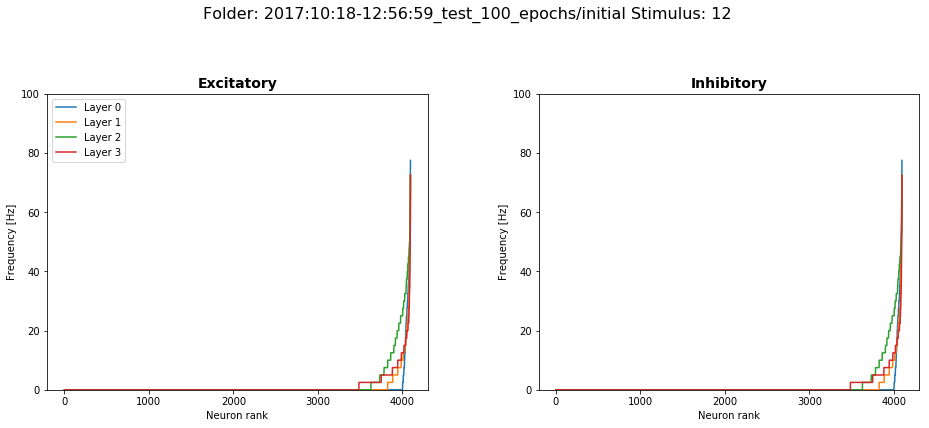

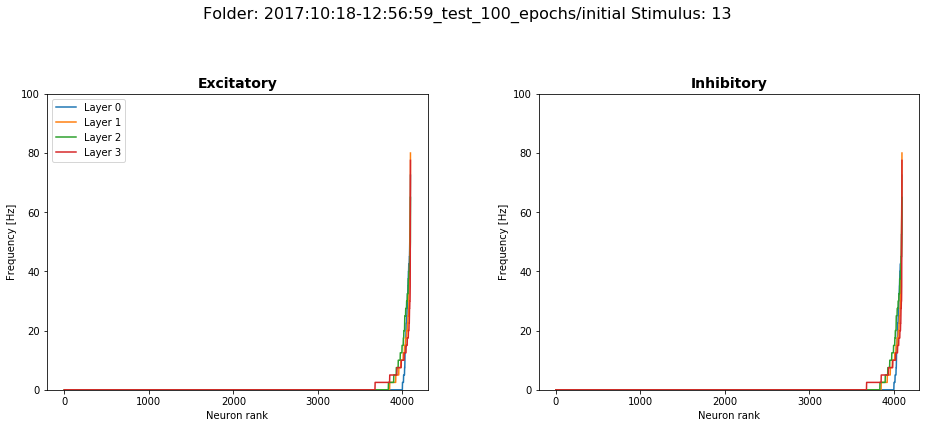

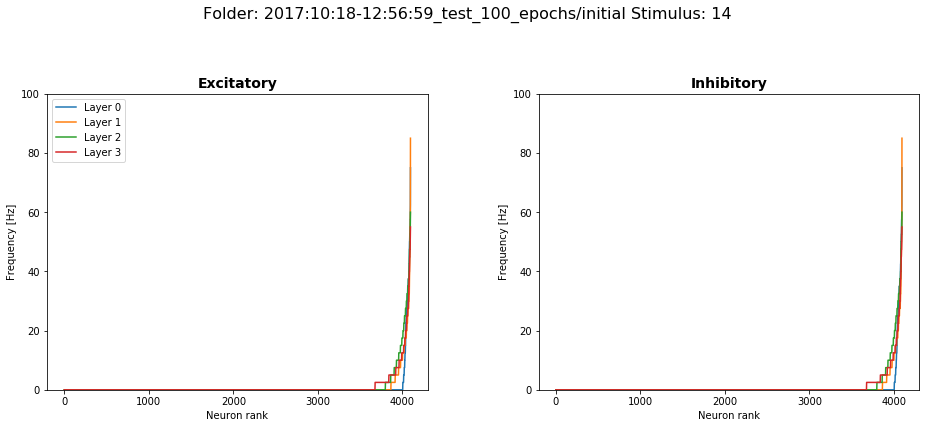

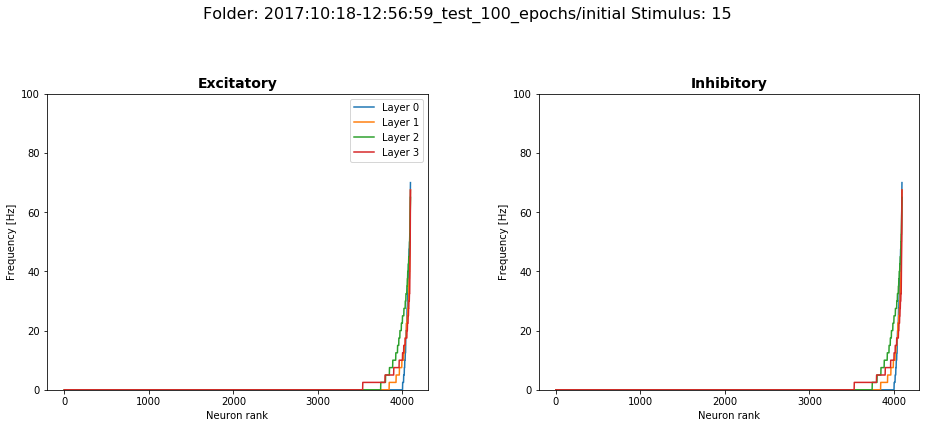

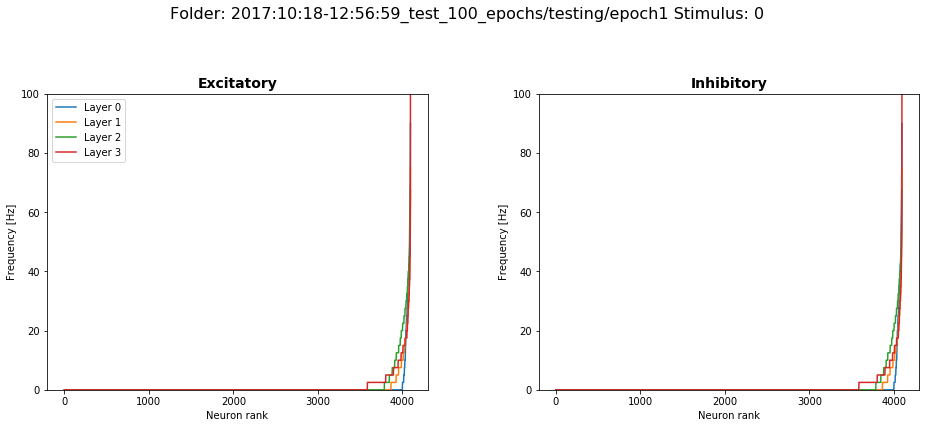

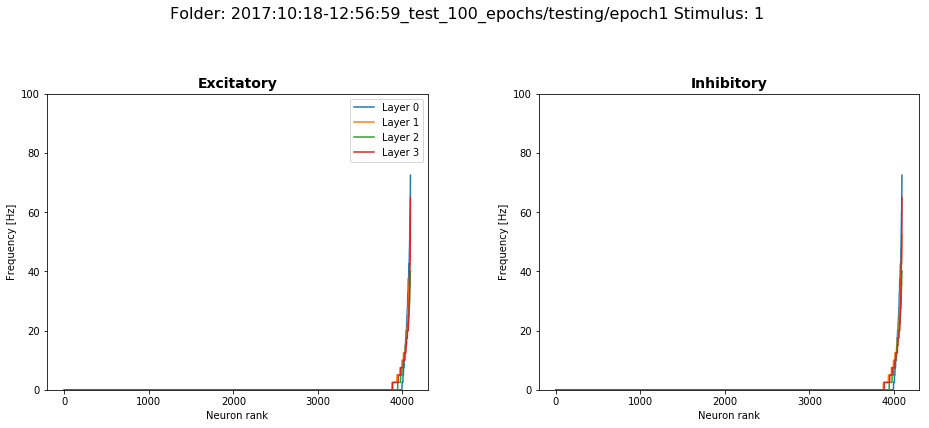

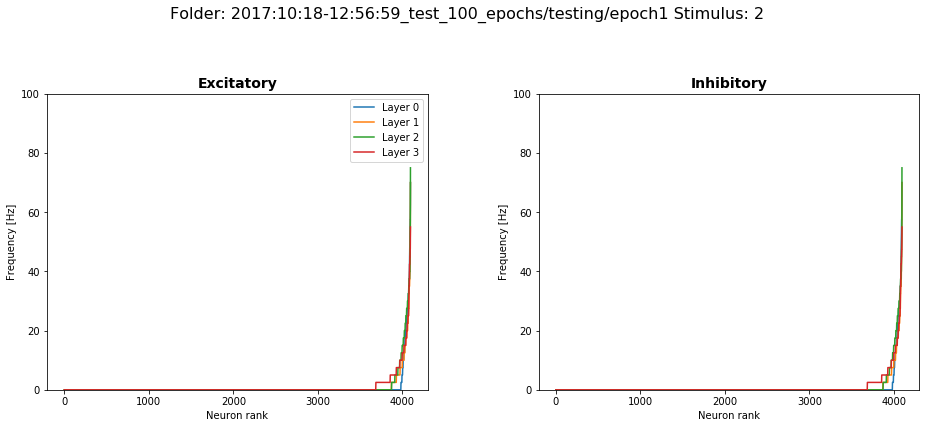

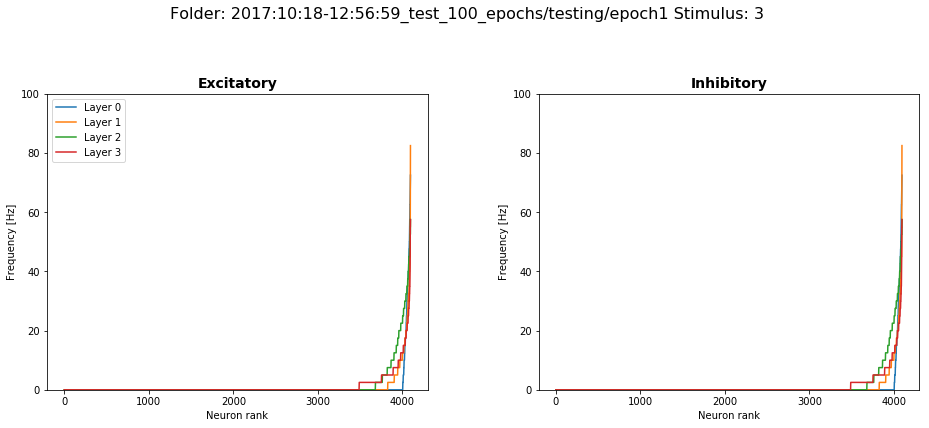

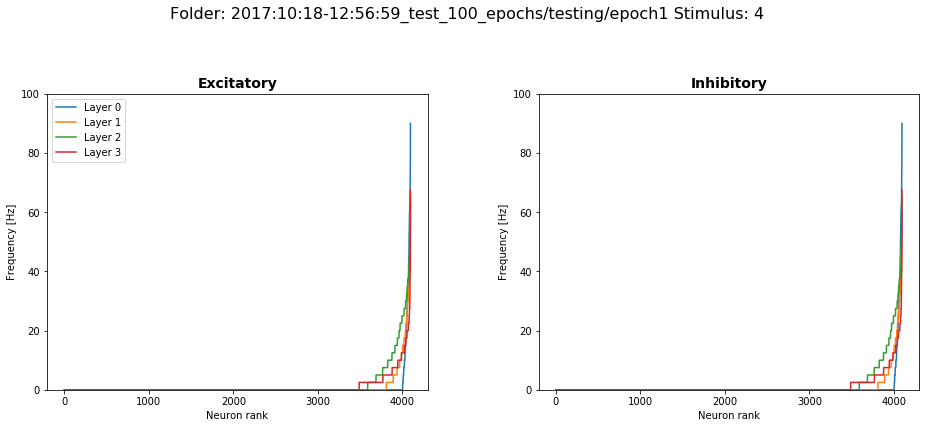

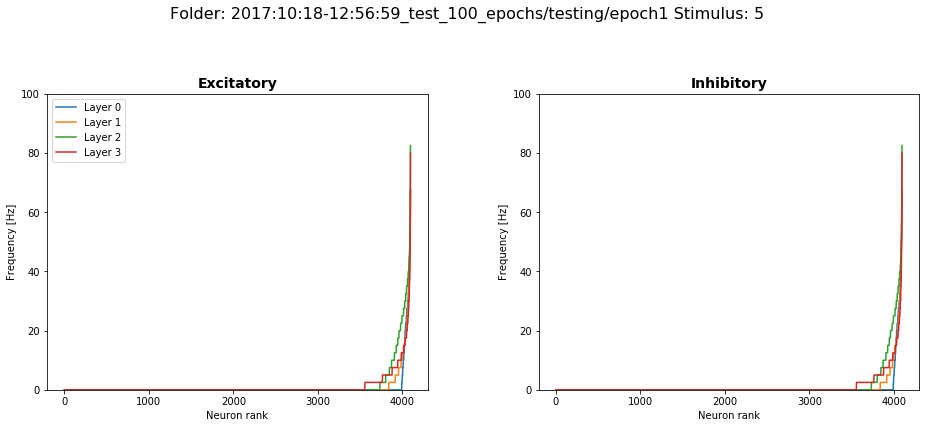

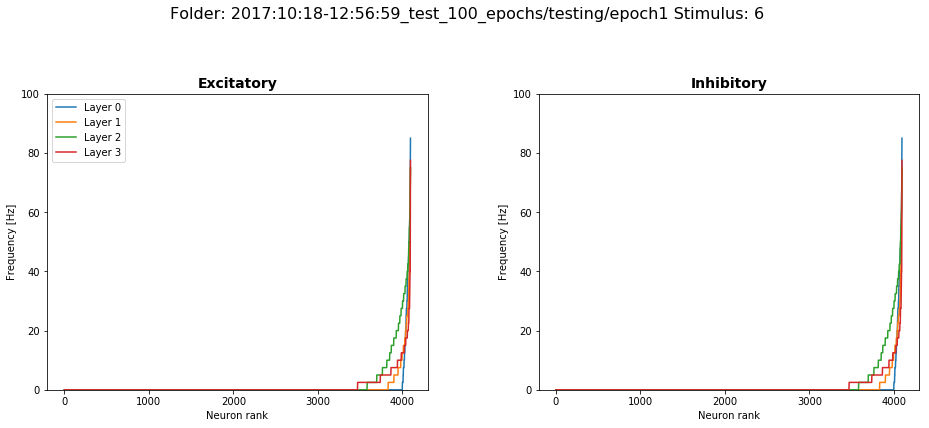

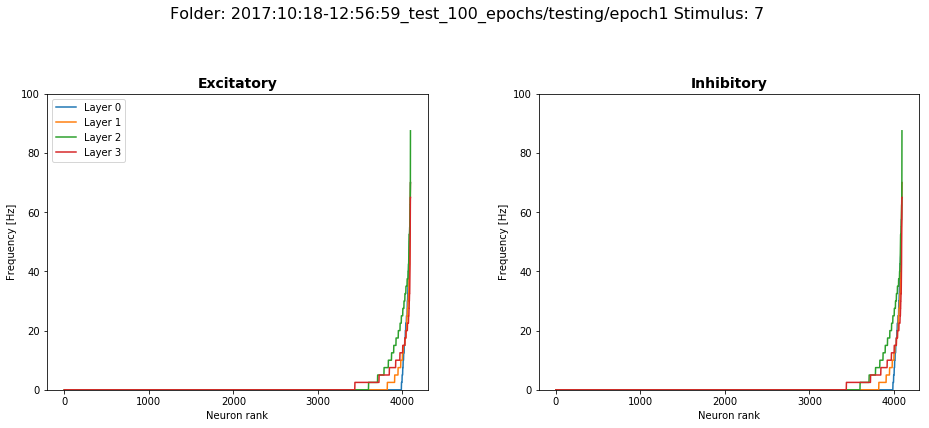

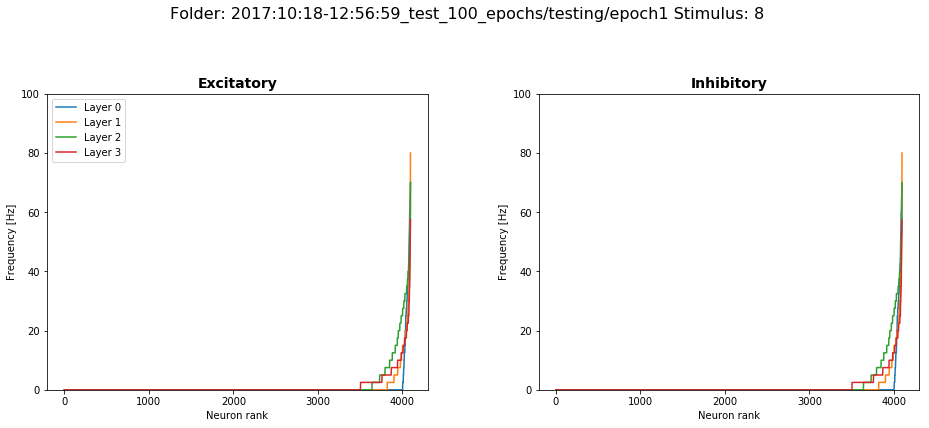

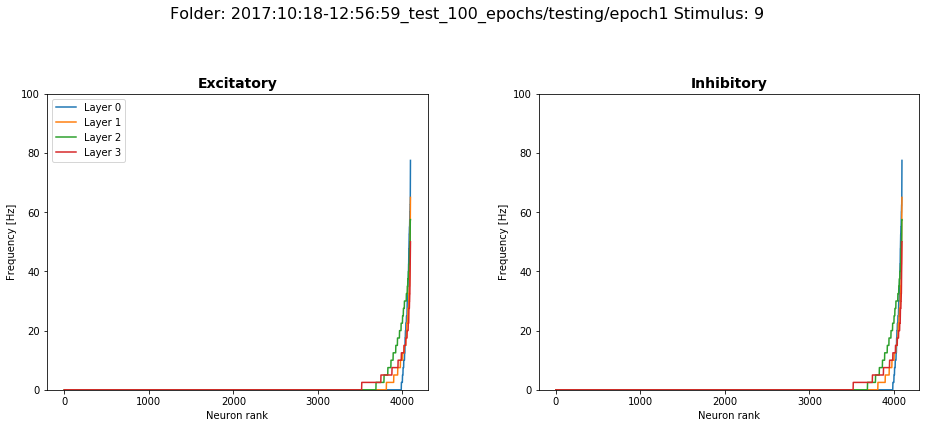

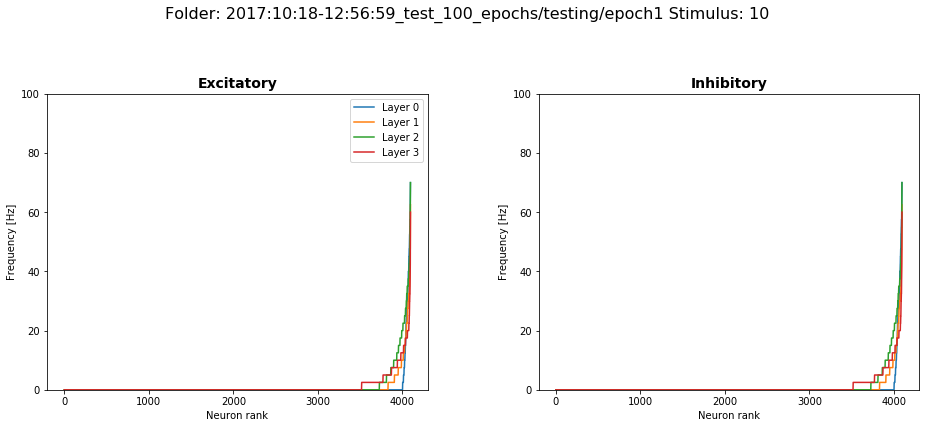

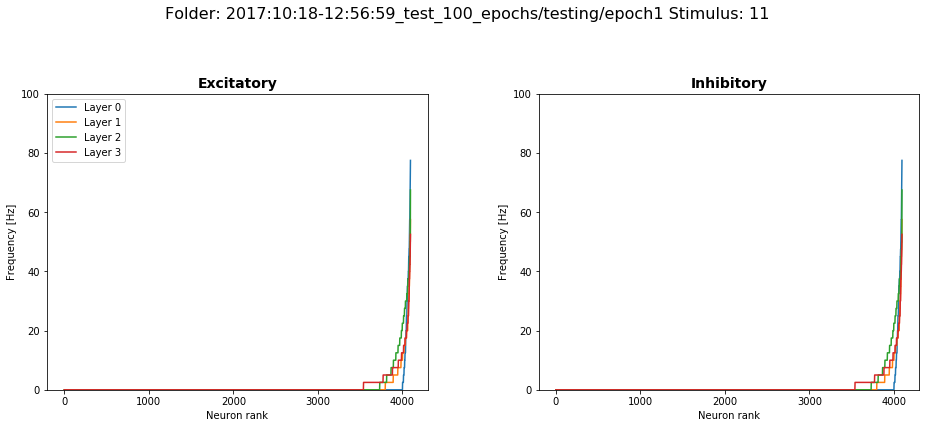

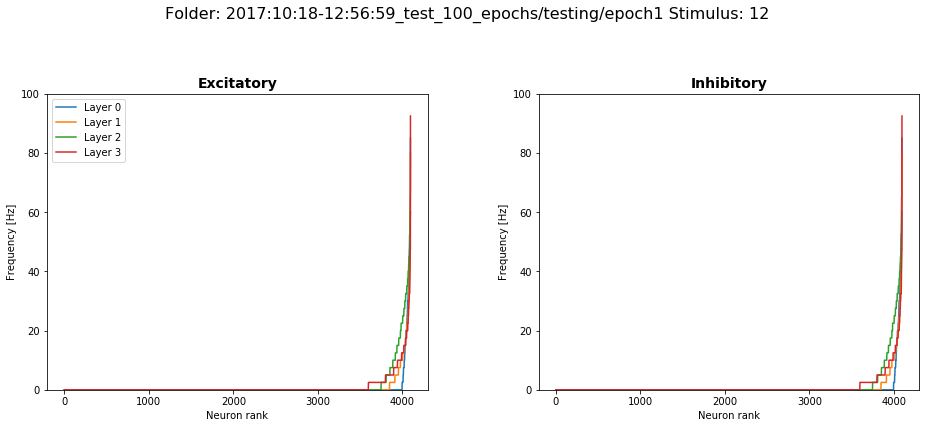

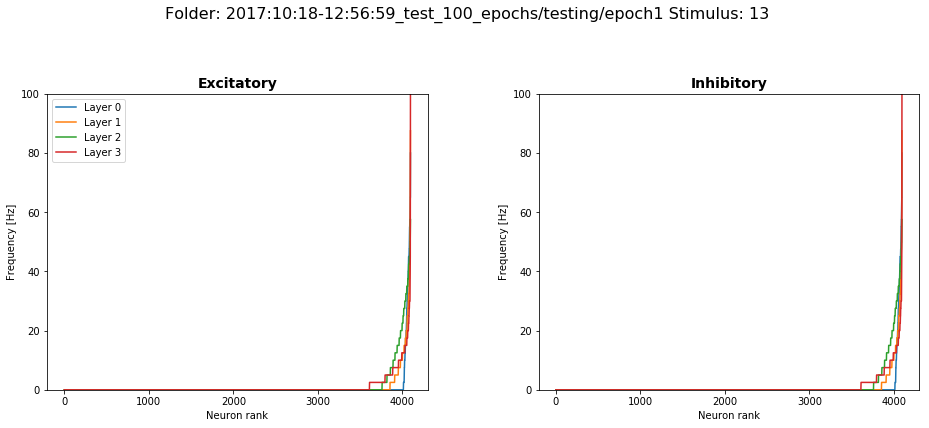

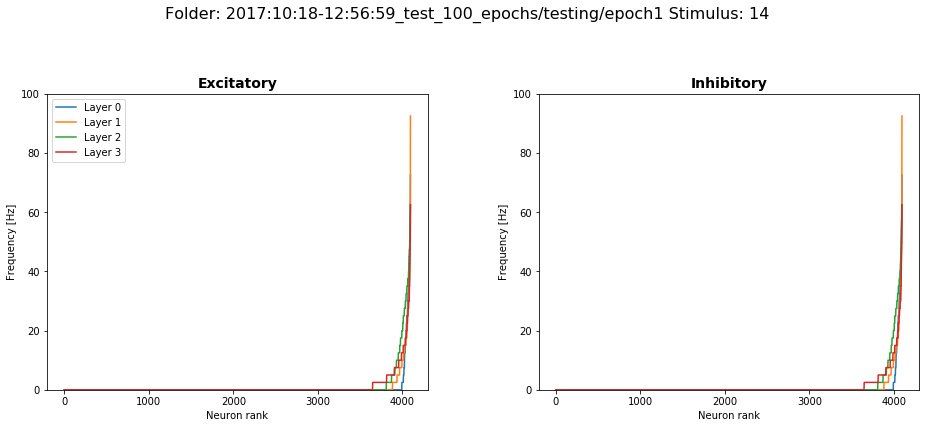

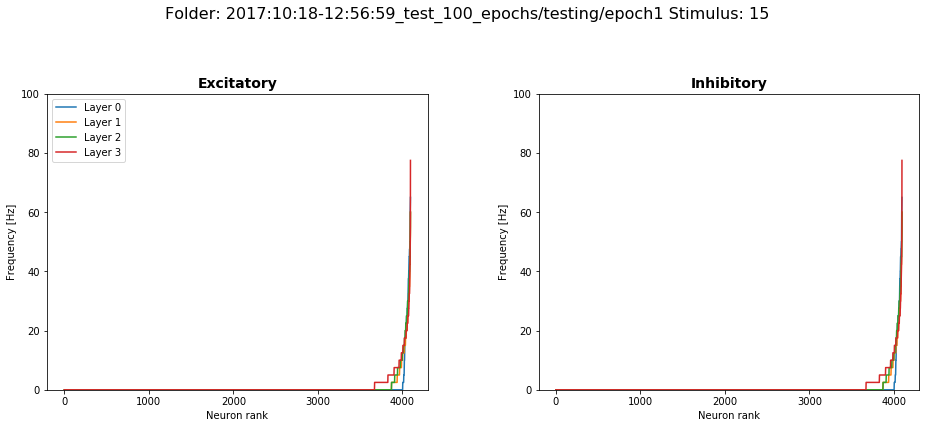

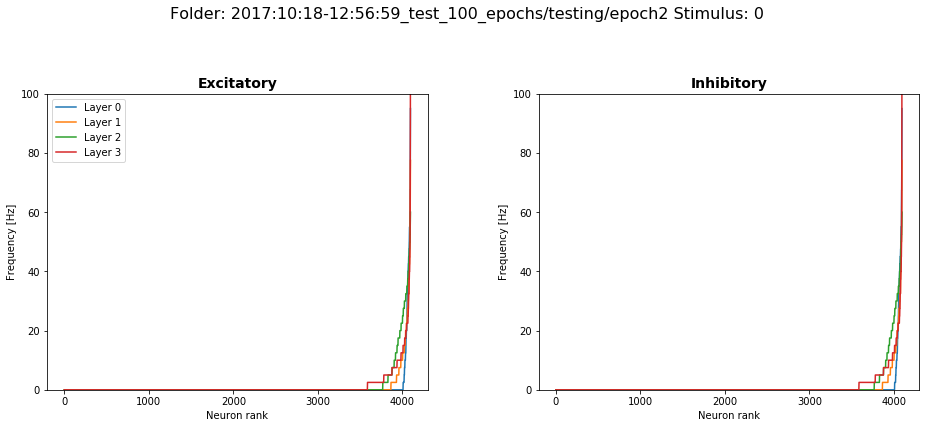

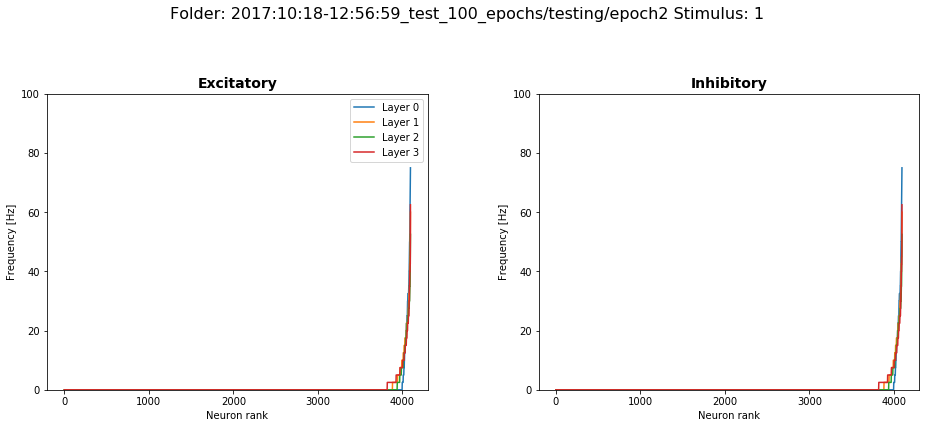

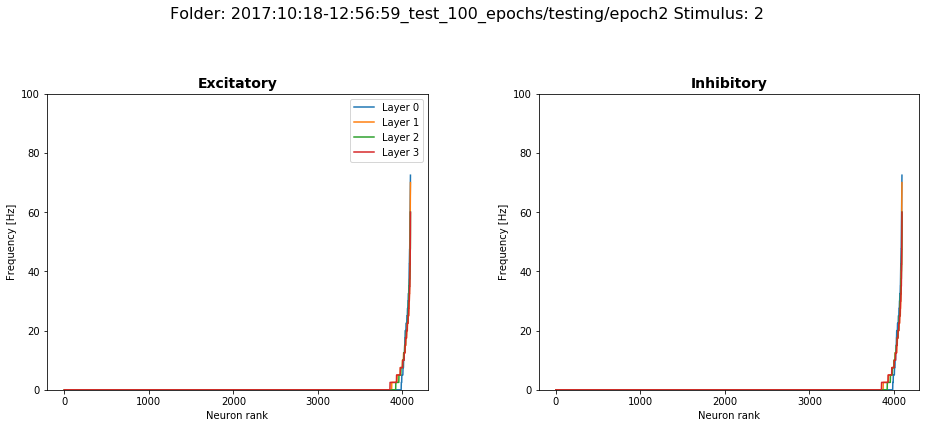

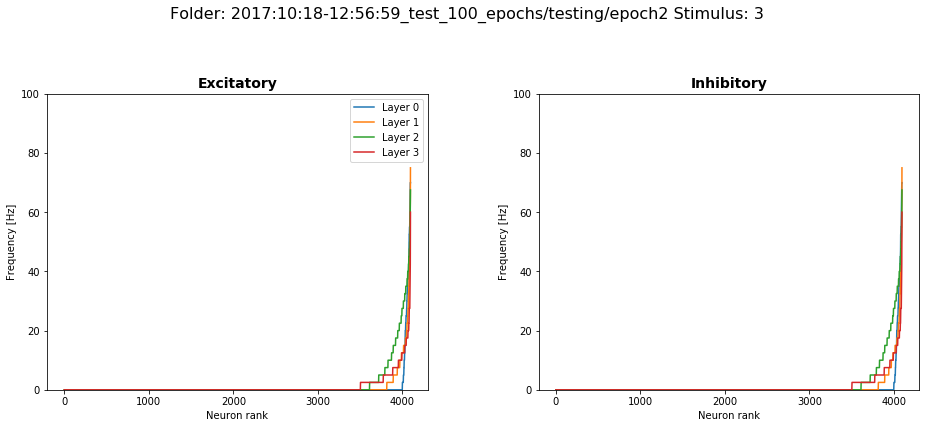

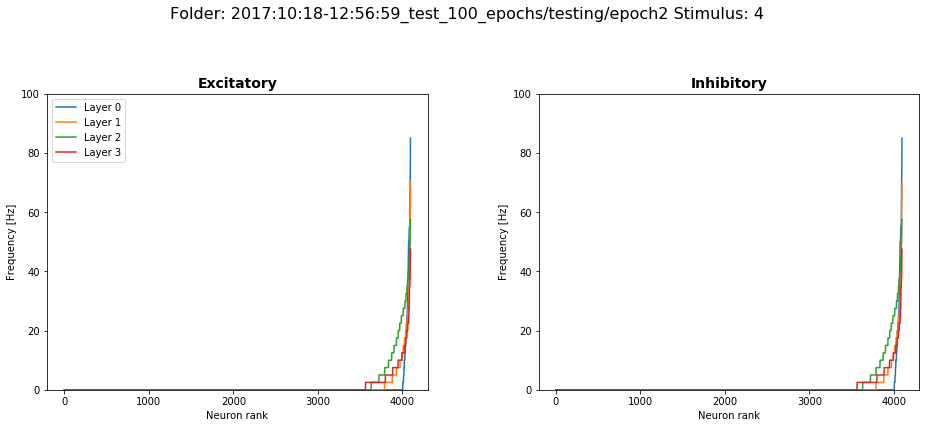

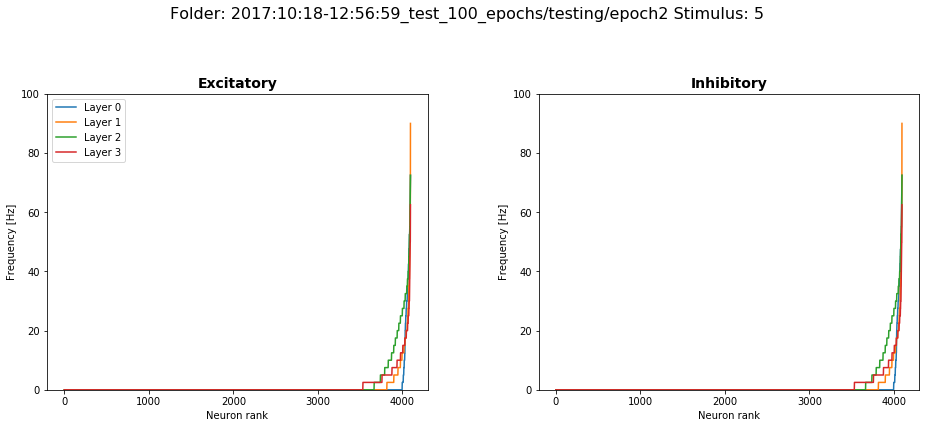

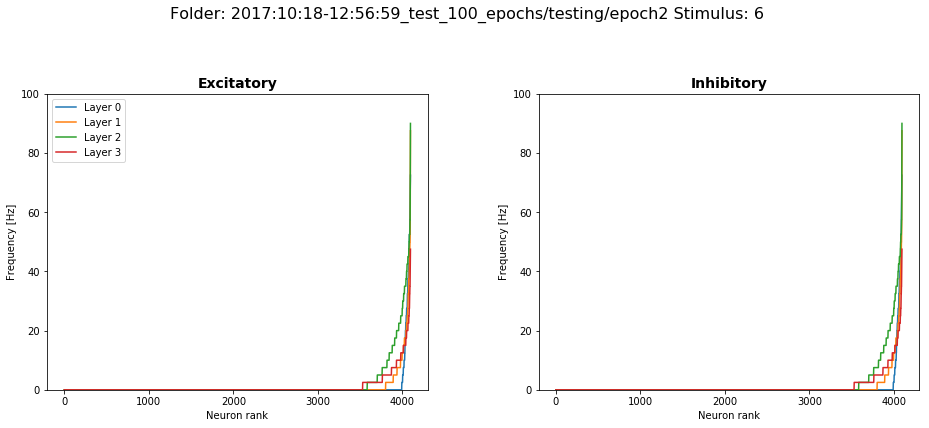

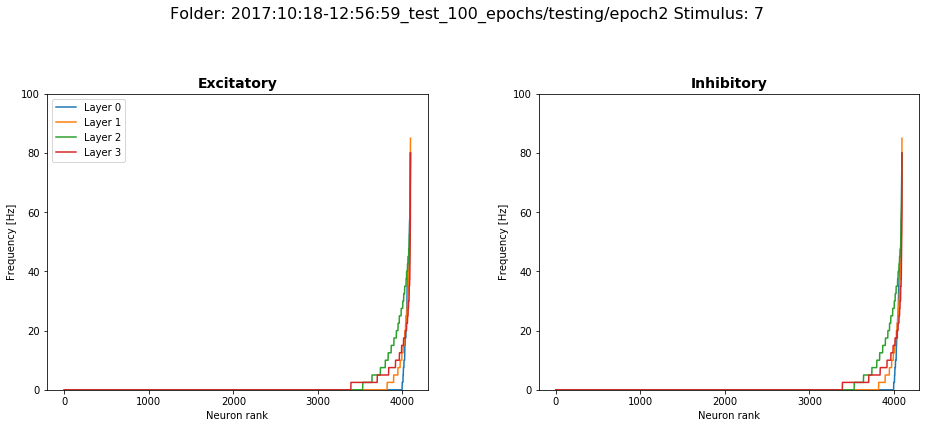

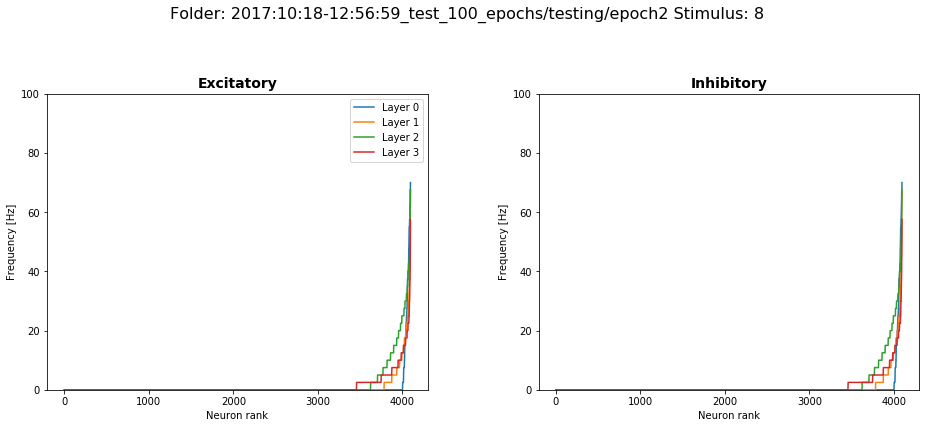

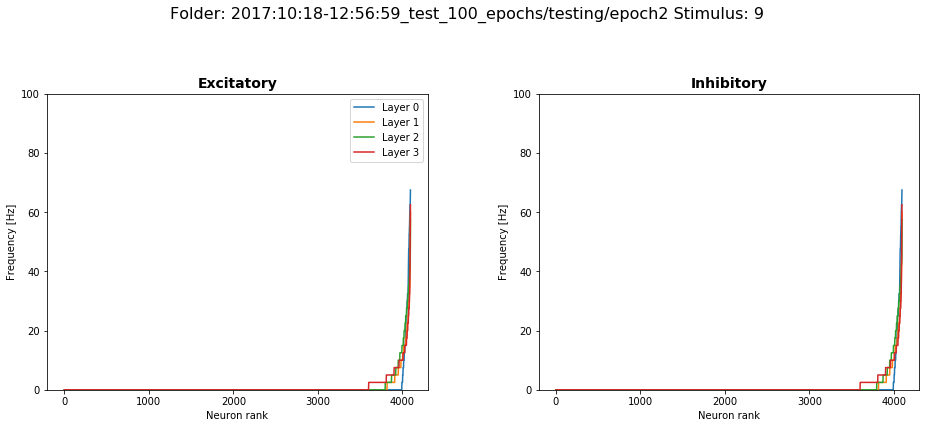

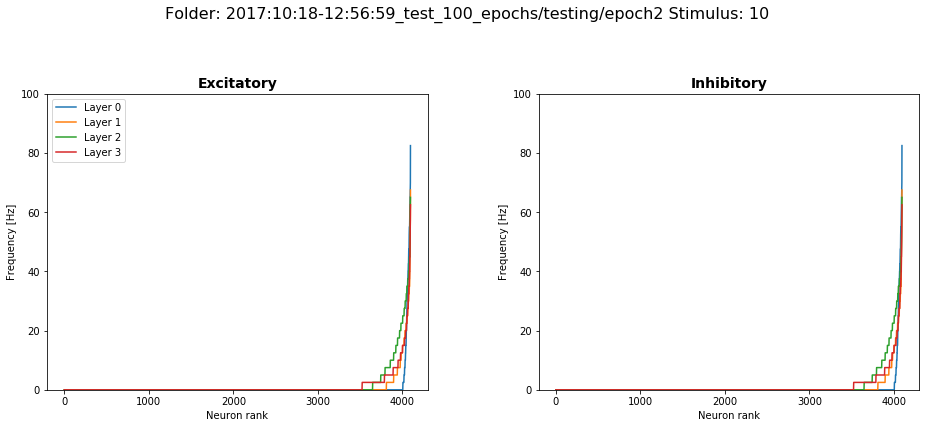

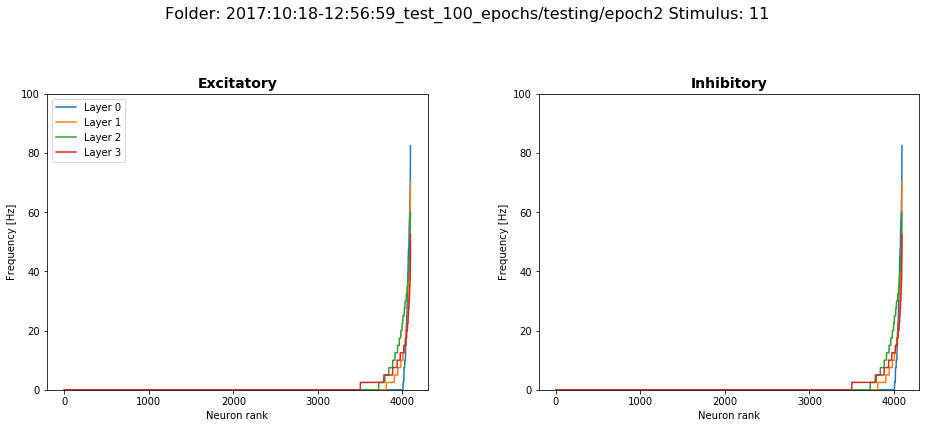

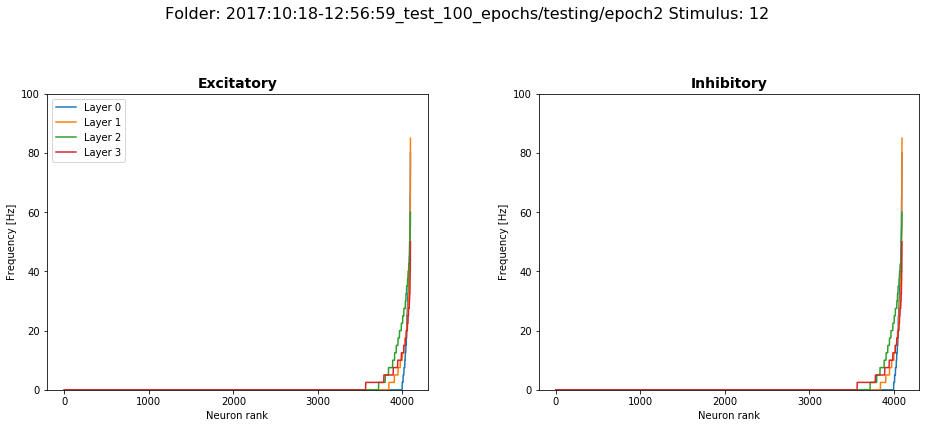

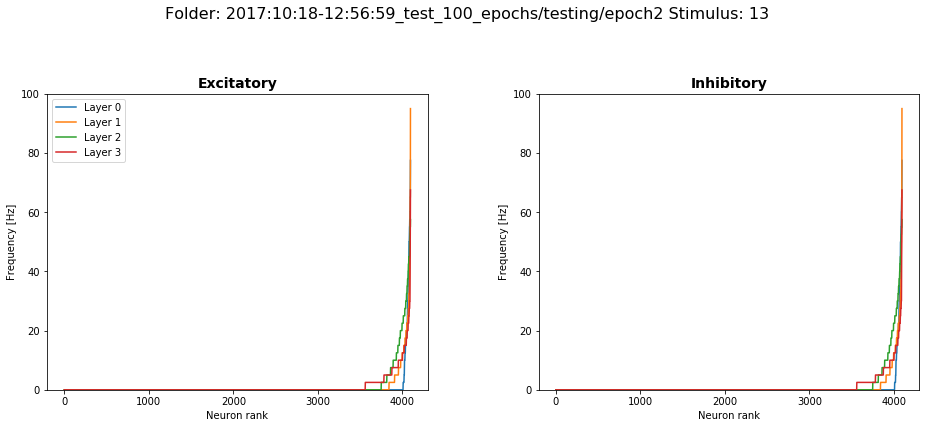

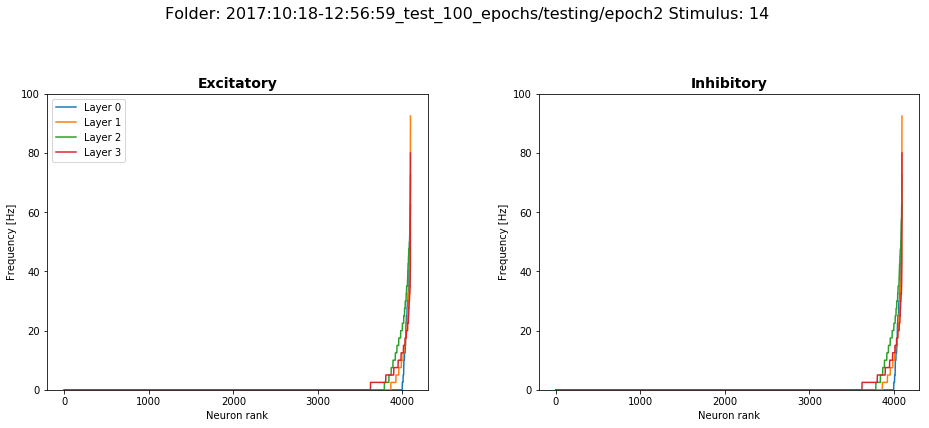

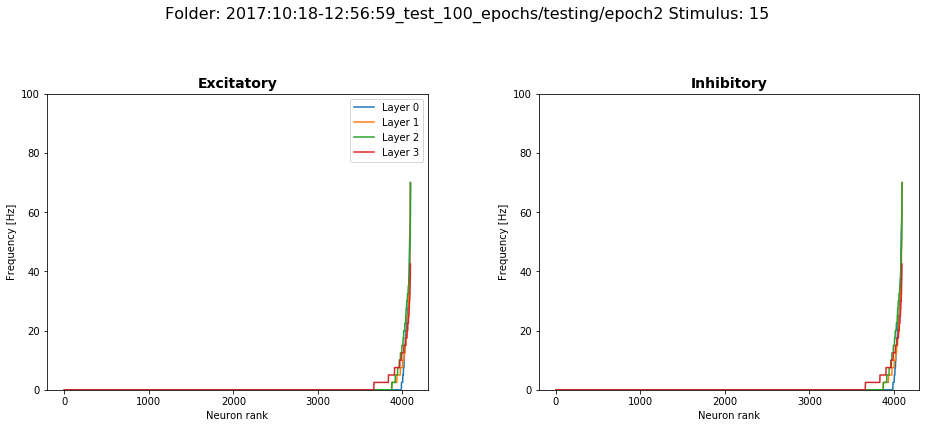

In [6]:
num_stimuli=info_times["num_stimuli"]
num_layers= network_architecture["num_layers"]
neuron_type = 'exc'
neuron_type_id = {'exc':0, 'inh':1}[neuron_type]


for sub_id, subfolder in enumerate(subfolders):
    for ext_id, extension in enumerate(extensions):
        exitatory_rates, inhibitory_rates = helper.stimulus_layer_nested_list_2_numpy_tensor(rates_subfolders[sub_id][ext_id])
        #dimensions: [stimulus, layer, neuron_id]
        exc_rates_sorted = np.sort(exitatory_rates, axis=2) #sort so that the firing rates in each stimulus and layer are sorted
        #dimensions: [stimulus, layer, neuron_activity_rank]
        inh_rates_sorted = np.sort(inhibitory_rates, axis=2)
        
       
        for stimulus in range(num_stimuli):                        
            fig = plt.figure(figsize=(15, 7))
            fig.suptitle("Folder: {}/{} Stimulus: {}".format(subfolder, extension, stimulus), fontsize=16)
            
            subpltEX = fig.add_subplot(1, 2, 1)
            plt.tight_layout(pad=8.0)
            subpltEX.set_title("Excitatory", fontsize = 14, fontweight="bold")
            subpltEX.set_ylabel("Frequency [Hz]")
            subpltEX.set_xlabel("Neuron rank")
            subpltEX.set_ylim(0, 100)
            
            subpltIN = fig.add_subplot(1, 2, 2)
            plt.tight_layout(pad=8.0)
            subpltIN.set_title("Inhibitory", fontsize = 14, fontweight="bold")
            subpltIN.set_ylabel("Frequency [Hz]")
            subpltIN.set_xlabel("Neuron rank")
            subpltIN.set_ylim(0, 100)
            
            for layer in range(num_layers):
                subpltEX.plot(exc_rates_sorted[stimulus, layer], label="Layer {}".format(layer))               
                subpltIN.plot(exc_rates_sorted[stimulus, layer], label="Layer {}".format(layer))
                
            subpltEX.legend()

### Visualize firing rates spatially

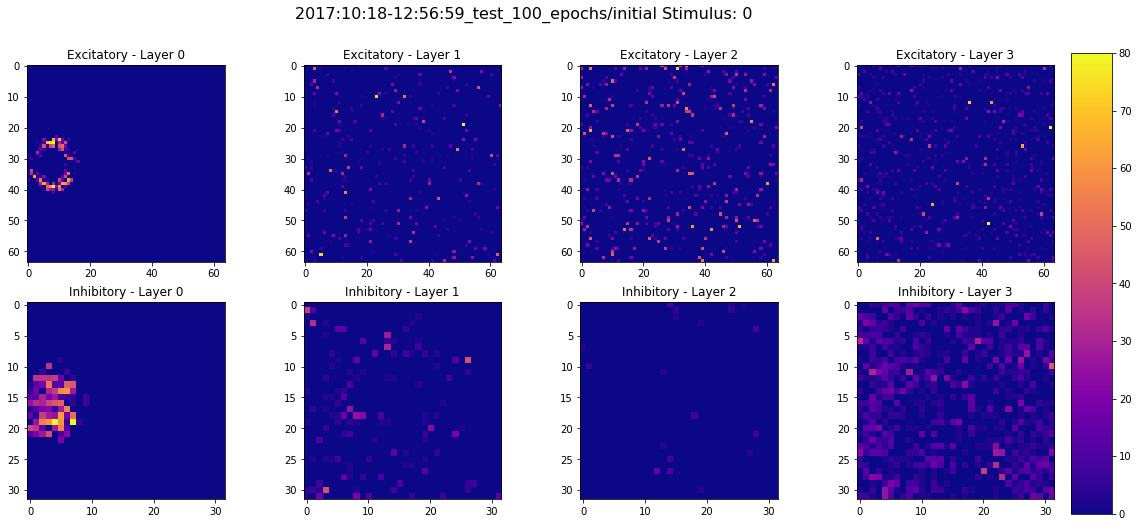

In [7]:
num_layers = network_architecture["num_layers"]
num_stimuli = info_times["num_stimuli"]
layer_dims_exc = int(np.sqrt(network_architecture["num_exc_neurons_per_layer"]))
layer_dims_inh = int(np.sqrt(network_architecture["num_inh_neurons_per_layer"]))

subfolder_ids = [0]
extension_ids = [0]
stimuli_ids = [0]
max_firing_rate = 80

for subfolder in subfolder_ids:
    for extension in extension_ids:
        rates_atomic_folder = rates_subfolders[subfolder][extension]
        exc_rates, inh_rates = helper.stimulus_layer_nested_list_2_numpy_tensor(rates_atomic_folder)
        #each a numpy array of shape [stimulus, layer, neuron_id]
        
        #exc_rates_imgs = exc_rates.reshape((num_stimuli, num_layers, layer_dims_exc, layer_dims_exc), order='F')
        exc_rates_imgs = helper.reshape_into_2d(exc_rates)
        inh_rates_imgs = helper.reshape_into_2d(inh_rates)
        
        for stimulus in stimuli_ids:
            fig = plt.figure(figsize=(19, 8))
            fig.suptitle("{}/{} Stimulus: {}".format(subfolders[subfolder], extensions[extension], stimulus), fontsize=16)
            
            for layer in range(num_layers):
                        
                subPlotAX = fig.add_subplot(2, num_layers, layer+1)
                           
                subPlotAX.set_title("Excitatory - Layer " + str(layer))
                subPlotAX.imshow(exc_rates_imgs[stimulus, layer, :, :], vmin=0, vmax=max_firing_rate, cmap='plasma')
                
                subPlotAXinh = fig.add_subplot(2, num_layers, num_layers + layer+1)
                           
                subPlotAXinh.set_title("Inhibitory - Layer " + str(layer))
                im = subPlotAXinh.imshow(inh_rates_imgs[stimulus, layer, :, :], vmin=0, vmax=max_firing_rate, cmap='plasma')
            
            cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
            fig.colorbar(im, cax=cax)

                    

### Animated Plots
You can pick a stimulus and it will show an animated video of the instantanious firing rate

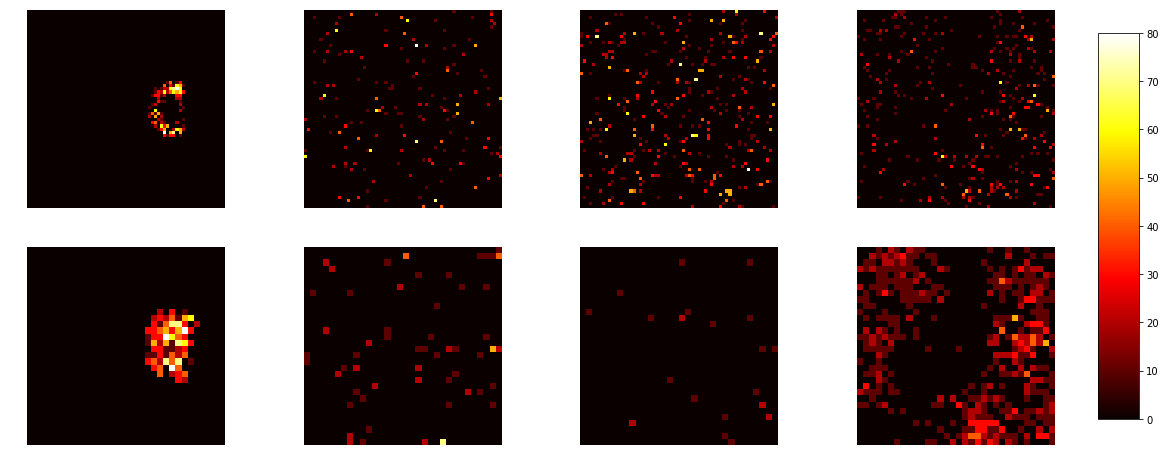

In [10]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='html5')

## Pick your stimulus
subfolder = 0
extension= 2
stimulus = 6
## And the time Step
time_step = 0.1

spikes_stimulus = helper.splitstimuli(spikes[subfolder][extension], 2.0)[stimulus]
times, exc, inh = firing.instant_FR_for_all_layers(spikes_stimulus, network_architecture, time_step)
n_timepoints = exc.shape[1] 
n_layers = exc.shape[0]
exc_img = helper.reshape_into_2d(exc)
inh_img = helper.reshape_into_2d(inh)

fig = plt.figure(figsize=(19,8))

exc_axes = []
inh_axes = []
for l in range(n_layers):
    exc_axes.append(fig.add_subplot(2, n_layers, 1 + l))
    exc_axes[-1].axis('off')
for l in range(n_layers):
    inh_axes.append(fig.add_subplot(2, n_layers, n_layers + 1 + l))
    inh_axes[-1].axis('off')
    
ims = []
for frame in range(n_timepoints):
    #image_arr = np.reshape(exc[3, frame, :], (64, 64), order='F')
    images_Ex = []
    images_In = []
    for l in range(n_layers):
        imEx = exc_axes[l].imshow(exc_img[l, frame, :, :], animated=True, cmap='hot', vmin=0, vmax=max_firing_rate)
        imIn = inh_axes[l].imshow(inh_img[l, frame, :, :], animated=True, cmap='hot', vmin=0, vmax=max_firing_rate)
        
        images_Ex.append(imEx)
        images_In.append(imIn)
        
    ims.append(images_Ex + images_In)

cax = fig.add_axes([0.92, 0.17, 0.03, 0.67])
fig.colorbar(imIn, cax=cax)


ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=22000)
HTML(ani.to_html5_video())